In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import sys
import tensorflow as tf
import numpy as np
import pandas as pd
print(tf.__version__)
print(sys.version)
#print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('Tensorflow version is {}.'.format(tf.__version__))
print('The Pandas version is {}.'.format(pd.__version__))
print('The Numpy version is {}.'.format(np.__version__))

2.1.0
3.6.10 |Anaconda, Inc.| (default, Mar 23 2020, 17:58:33) [MSC v.1916 64 bit (AMD64)]
Tensorflow version is 2.1.0.
The Pandas version is 1.0.3.
The Numpy version is 1.19.2.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
#!wget --no-check-certificate \
#    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
#    -O /tmp/daily-min-temperatures.csv
import os
path = r'C:\Users\pmspr\Documents\Machine Learning\Courses\Tensorflow Cert\Git\Tensorflow-Cert\Coursera\01 - Data'
folder = 'timeseries'
abs_path = os.path.join(path,folder)
if not os.path.exists(os.path.join(abs_path, 'daily-min-temperatures.csv')):
    tem_ser_r = tf.keras.utils.get_file('daily-min-temperatures.csv',
                                        cache_subdir=abs_path,
                                        origin = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv',
                                        extract = True)

    tem_ser = abs_path
else:
    tem_ser = abs_path

filename = os.path.join(tem_ser, 'daily-min-temperatures.csv')

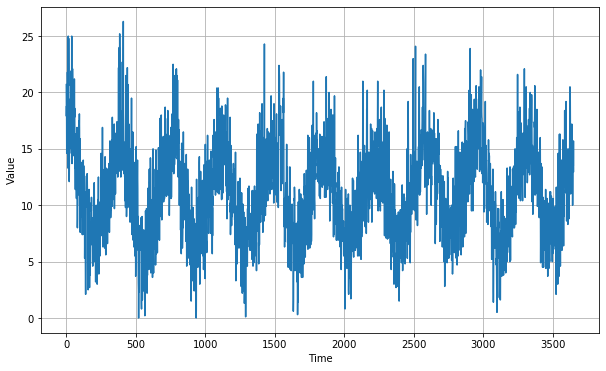

In [5]:
import csv
time_step = []
temps = []

with open(filename) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1])) #w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 5s 499ms/step - loss: 31.1577 - mae: 31.6401
Epoch 2/100
10/10 [==============================] - 2s 216ms/step - loss: 30.5724 - mae: 31.0666
Epoch 3/100
10/10 [==============================] - 2s 218ms/step - loss: 29.6354 - mae: 30.1716
Epoch 4/100
10/10 [==============================] - 2s 220ms/step - loss: 28.5379 - mae: 29.0540
Epoch 5/100
10/10 [==============================] - 2s 227ms/step - loss: 27.2542 - mae: 27.6949
Epoch 6/100
10/10 [==============================] - 2s 218ms/step - loss: 25.4701 - mae: 25.9945
Epoch 7/100
10/10 [==============================] - 2s 210ms/step - loss: 23.3427 - mae: 23.8330
Epoch 8/100
10/10 [==============================] - 2s 217ms/step - loss: 20.5304 - mae: 21.0974
Epoch 9/100
10/10 [==============================] - 2s 218ms/step - loss: 17.1900 - mae: 17.7874
Epoch 10/100
10/10 [==

10/10 [==============================] - 2s 221ms/step - loss: 4.8131 - mae: 5.3308
Epoch 85/100
10/10 [==============================] - 2s 224ms/step - loss: 5.6438 - mae: 6.1857
Epoch 86/100
10/10 [==============================] - 2s 227ms/step - loss: 6.3068 - mae: 6.8790
Epoch 87/100
10/10 [==============================] - 2s 234ms/step - loss: 6.9501 - mae: 7.5982
Epoch 88/100
10/10 [==============================] - 2s 227ms/step - loss: 9.1474 - mae: 9.7039
Epoch 89/100
10/10 [==============================] - 2s 221ms/step - loss: 9.0000 - mae: 9.6136
Epoch 90/100
10/10 [==============================] - 2s 225ms/step - loss: 39.5845 - mae: 38.0987
Epoch 91/100
10/10 [==============================] - 2s 228ms/step - loss: 25.2258 - mae: 24.9145
Epoch 92/100
10/10 [==============================] - 2s 235ms/step - loss: 32.3089 - mae: 30.8144
Epoch 93/100
10/10 [==============================] - 2s 238ms/step - loss: 39.2699 - mae: 39.6214
Epoch 94/100
10/10 [===============

[1e-08, 0.0001, 0, 60]

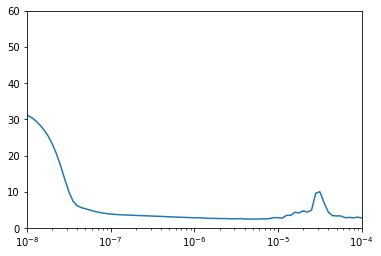

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 5s 216ms/step - loss: 9.8131 - mae: 10.4597
Epoch 2/150
25/25 [==============================] - 3s 108ms/step - loss: 2.7741 - mae: 3.2608
Epoch 3/150
25/25 [==============================] - 3s 107ms/step - loss: 2.3853 - mae: 2.8337
Epoch 4/150
25/25 [==============================] - 3s 110ms/step - loss: 2.3978 - mae: 2.8619
Epoch 5/150
25/25 [==============================] - 3s 110ms/step - loss: 2.3325 - mae: 2.7943
Epoch 6/150
25/25 [==============================] - 3s 107ms/step - loss: 2.4434 - mae: 2.8900
Epoch 7/150
25/25 [==============================] - 3s 108ms/step - loss: 2.3554 - mae: 2.8169
Epoch 8/150
25/25 [==============================] - 3s 108ms/step - loss: 2.3191 - mae: 2.7788
Epoch 9/150
25/25 [==============================] - ETA: 0s - loss: 2.4239 - mae: 2.885 - 3s 107ms/step - loss: 2.4006 - mae: 2.8760
Epoch 10/150
25/25 [==============================] - 3s 110ms/step - loss: 2.2812 - mae: 2.7465


25/25 [==============================] - 3s 110ms/step - loss: 2.2054 - mae: 2.6686
Epoch 84/150
25/25 [==============================] - 3s 111ms/step - loss: 2.1637 - mae: 2.6228
Epoch 85/150
25/25 [==============================] - 3s 107ms/step - loss: 2.2685 - mae: 2.7202
Epoch 86/150
25/25 [==============================] - 3s 110ms/step - loss: 2.1797 - mae: 2.6416
Epoch 87/150
25/25 [==============================] - 3s 107ms/step - loss: 2.1848 - mae: 2.6540
Epoch 88/150
25/25 [==============================] - 3s 109ms/step - loss: 2.2565 - mae: 2.7243 1s - loss: 2.2937 - ma
Epoch 89/150
25/25 [==============================] - 3s 110ms/step - loss: 2.2201 - mae: 2.6834
Epoch 90/150
25/25 [==============================] - 3s 108ms/step - loss: 2.2227 - mae: 2.6817
Epoch 91/150
25/25 [==============================] - 3s 112ms/step - loss: 2.1924 - mae: 2.6517
Epoch 92/150
25/25 [==============================] - 3s 115ms/step - loss: 2.1815 - mae: 2.6522 1s - loss: 2.2911 
E

In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

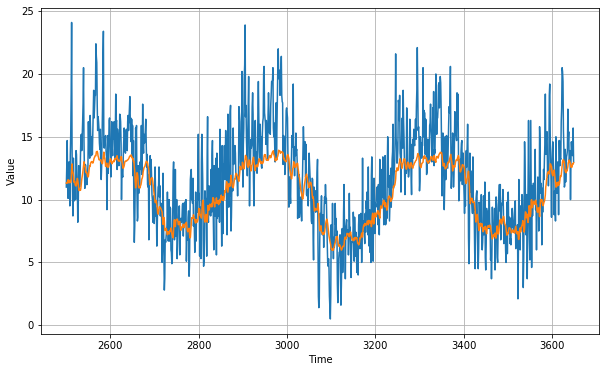

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.2189214

In [ ]:
print(rnn_forecast)

[11.636601 10.97607  12.159701 ... 13.589686 13.726407 14.940471]
